# Longitudinal Pump

In [2]:
using QuantumOptics, PyPlot, Printf, LinearAlgebra

In [3]:
# Define Parameters
N_cutoff = 16
xmin = 0
xmax = 1
Nsteps = 32

k = 2*π
ωr = 1

Δc = -30 * ωr
U0 = -10 * ωr;

In [4]:
# Bases
b_position = PositionBasis(xmin, xmax, Nsteps)
b_fock = FockBasis(N_cutoff)

# Operators for atom
p = momentum(b_position)

# Operators for cavity
a = destroy(b_fock) ⊗ one(b_position)
ad = dagger(a);

In [5]:
# Hamiltonian and calculate states
potential = x -> U0*cos(k*x)^2
H_int = (one(b_fock) ⊗ potentialoperator(b_position, potential))*ad*a
H_kin = (one(b_fock) ⊗ p^2) / k^2
H_cavity = -Δc*ad*a

function H(η)
    H_kin + dense(H_int) + H_cavity + η*(a + ad)
end;

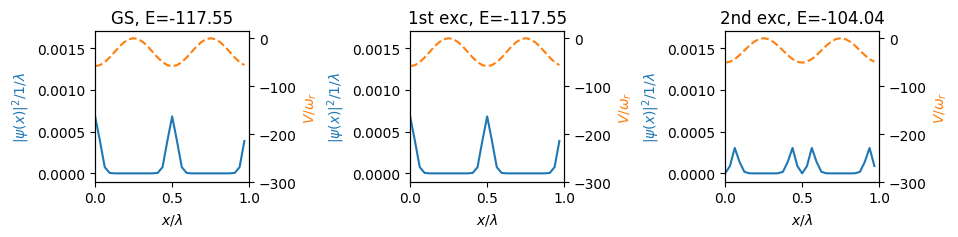

In [20]:
η = 50 * ωr
E, ψ_states = eigenstates((H(η) + dagger(H(η)))/2, 3);

# Plot position
xpoints = samplepoints(b_position)

fig = figure()

for i in 1:3
    plt_index = 330 + i
    host = fig.add_subplot(plt_index)
    par1 = host.twinx()
    
    pos_dense = ptrace(ψ_states[i], 1)
    density = diag(pos_dense.data)
    ada_exp = expect(ad*a, ψ_states[i])
    pot = @. U0*cos(k*xpoints)^2*real(ada_exp)
    
    host.set_xlim(xmin, xmax)
    host.set_ylim(-0.0001, 0.0017)
    par1.set_ylim(-299.233685, 14.249223)
    host.plot(xpoints, abs2.(density ./ sqrt(Nsteps)), "C0")
    par1.plot(xpoints, pot, "C1", linestyle="--")
    
    host.set_xlabel(L"x / \lambda")
    host.set_ylabel(L"|\psi(x)|^2 / 1/\lambda")
    par1.set_ylabel(L"V / \omega_r")
    host.yaxis.label.set_color("C0")
    par1.yaxis.label.set_color("C1")
    
    # Boundaries
#     println("host.set_ylim(" *@sprintf("%.4f", host.get_ylim()[1]) *", " *@sprintf("%.4f", host.get_ylim()[2]) *")")
#     println("par1.set_ylim(" *@sprintf("%.6f", par1.get_ylim()[1]) *", " *@sprintf("%.6f", par1.get_ylim()[2]) *")")
    
    if i == 1
        title("GS, E=" * @sprintf("%.2f", E[1]))
    elseif i == 2
        title("1st exc, E=" * @sprintf("%.2f", E[2]))
    else
        title("2nd exc, E=" * @sprintf("%.2f", E[3]))
    end
end

tight_layout(rect=[0, 0, 1.5, 1.3])

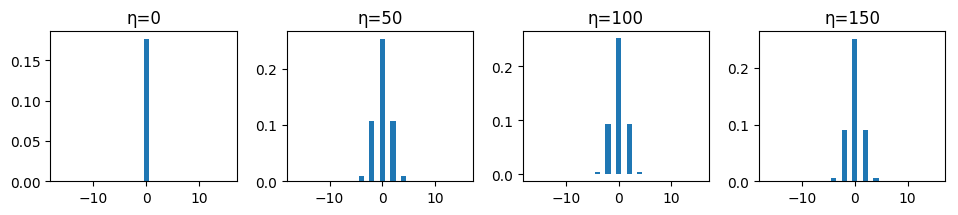

In [7]:
# Plot momentum
b_momentum = MomentumBasis(b_position)
Tpx = transform(b_momentum, b_position)

η_arr = [0:50:150;] .* ωr

fig = figure()
for i in 1:size(η_arr)[1]
    plt_index = size(η_arr)[1]*110 + i
    host = fig.add_subplot(plt_index)
#     host.set_xlim(xmin, xmax)
#     host.set_ylim(-0.0001, 0.0017)
    
    E, ψ_states = eigenstates((H(η_arr[i]) + dagger(H(η_arr[i])))/2, 1);
    pos_dense = ptrace(ψ_states[1], 1)
    states_p = Tpx * pos_dense
    density_p = diag(states_p.data)

    host.bar([-Nsteps/2:1:Nsteps/2-1;], density_p, width=1)
    title("η=$(η_arr[i])")
    
#     host.set_xlabel(L"x")
#     host.set_ylabel(L"|\psi(x)|^2")
#     host.yaxis.label.set_color("C0")
end
tight_layout(rect=[0, 0, 1.5, 1.6])

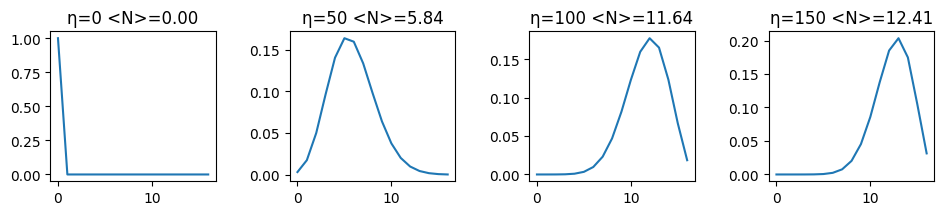

In [8]:
rc("text", usetex=false)
rc("font", family="sans")

# Plot photon number
η_arr = [0:50:150;] .* ωr

fig = figure()
for i in 1:size(η_arr)[1]
    plt_index = size(η_arr)[1]*110 + i
    host = fig.add_subplot(plt_index)
#     host.set_xlim(xmin, xmax)
#     host.set_ylim(-0.0001, 0.0017)
    
    E, ψ_states = eigenstates((H(η_arr[i]) + dagger(H(η_arr[i])))/2, 1);
    photon_dense = ptrace(ψ_states[1], 2)
    density_photon = diag(photon_dense.data)

    host.plot([0:1:16;], density_photon)
    ada_exp = expect(ad*a, ψ_states[1])
    title("η=$(η_arr[i]) <N>=" * @sprintf("%.2f", real(ada_exp)))
    
#     host.set_xlabel(L"x")
#     host.set_ylabel(L"|\psi(x)|^2")
#     host.yaxis.label.set_color("C0")
end
tight_layout(rect=[0, 0, 1.5, 1.6])

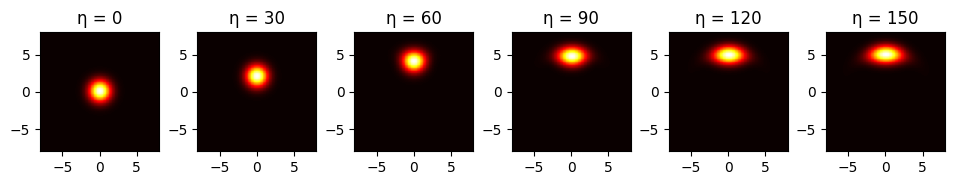

In [17]:
# Qfunc
η_arr = [0:30:150;] .* ωr

# Boundary
bdr = 8
xvec = [-bdr:.1:bdr;]
yvec = [-bdr:.1:bdr;]

fig = figure()

for i in 1:size(η_arr)[1]
    E, ψ_states = eigenstates((H(η_arr[i]) + dagger(H(η_arr[i]))) / 2, 1);

    plt_index = size(η_arr)[1] * 110 + i
    subplot(plt_index)
    husimi_q = qfunc(ptrace(ψ_states[1], 2), xvec, yvec)
    imshow(abs.(husimi_q), cmap="hot", interpolation="nearest", extent=(-bdr,bdr,-bdr,bdr));
    title("η = $(η_arr[i])")
end

tight_layout(rect=[0, 0, 1.5, 2]);

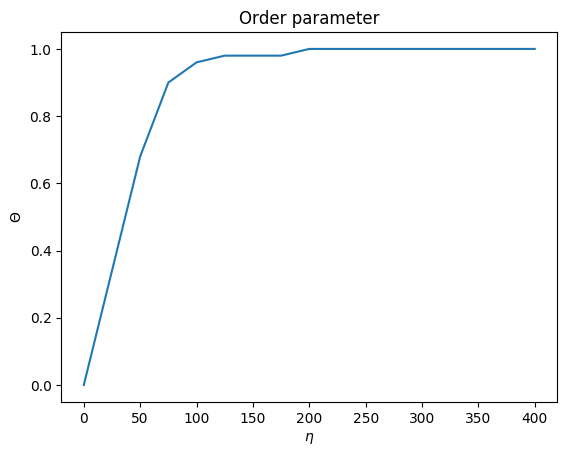

In [14]:
η_arr = [0:25:400;] .* ωr
bdr = 7
step = 0.1
xvec = [-bdr:step:bdr;]
yvec = [-bdr:step:bdr;]

order_param_arr = []
for i in 1:size(η_arr)[1]
    E, ψ_states = eigenstates((H(η_arr[i]) + dagger(H(η_arr[i]))) / 2, 1);
    husimi_q = qfunc(ptrace(ψ_states[1], 2), xvec, yvec)
    husimi_q_sub = husimi_q[1:trunc(Int, bdr/step+1),:]
    temp = abs(findmax(abs.(husimi_q_sub))[2][1] - (bdr/step+1)) / 50
    push!(order_param_arr, temp)
end

plot(η_arr, order_param_arr)
xlabel(L"\eta")
ylabel(L"\Theta")
title("Order parameter");